In [1]:
# Library imports
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# DATASET DIRECTORY CONFIGURATION
train_dir = "train"  # muffin vs chihuahua train folder
test_dir = "test"    # muffin vs chihuahua test folder

In [3]:
# IMAGE PARAMETERS
# VGG16 expects 224x224 input images
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [4]:
# DATA PREPROCESSING & AUGMENTATION
# VGG16 uses specific preprocessing (mean subtraction)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Changed to categorical for 3 classes
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Changed to categorical for 3 classes
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Changed to categorical for 3 classes
    shuffle=False
)

Found 1226 images belonging to 3 classes.
Found 305 images belonging to 3 classes.
Found 305 images belonging to 3 classes.
Found 657 images belonging to 3 classes.
Found 657 images belonging to 3 classes.


In [5]:
# Check class mapping
print("Class indices mapping:")
print(train_generator.class_indices)
print(f"\nTotal training images: {train_generator.samples}")
print(f"Total validation images: {val_generator.samples}")
print(f"Total test images: {test_generator.samples}")

Class indices mapping:
{'paper': 0, 'rock': 1, 'scissors': 2}

Total training images: 1226
Total validation images: 305
Total test images: 657


In [6]:
# LOAD PRE-TRAINED VGG16 MODEL
# Load VGG16 without top layers (fully connected layers)
# Use ImageNet weights, freeze convolutional base

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze the convolutional base
base_model.trainable = False

print("VGG16 base model loaded successfully!")
print(f"Total layers in base model: {len(base_model.layers)}")
print(f"Trainable: {base_model.trainable}")

VGG16 base model loaded successfully!
Total layers in base model: 19
Trainable: False


In [7]:
# BUILD MODEL WITH CUSTOM TOP LAYERS
# Add custom classification layers on top of VGG16

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # 3 classes: rock, paper, scissors
])

print("\nModel with custom top layers created!")
model.summary()


Model with custom top layers created!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,695,427 (105.65 MB)

 Trainable params: 12,979,203 (49.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

In [8]:
# COMPILE THE MODEL
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',  # Changed for multi-class classification
    metrics=['accuracy']
)

print("Model compiled successfully!")

Model compiled successfully!


In [9]:
# TRAINING THE MODEL
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 174s 4s/step - accuracy: 0.6941 - loss: 0.7790 - val_accuracy: 0.9311 - val_loss: 0.2098 - learning_rate: 1.0000e-04
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 174s 4s/step - accuracy: 0.6941 - loss: 0.7790 - val_accuracy: 0.9311 - val_loss: 0.2098 - learning_rate: 1.0000e-04
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - accuracy: 0.8997 - loss: 0.2773 - val_accuracy: 0.9574 - val_loss: 0.1010 - learning_rate: 1.0000e-04
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - accuracy: 0.8997 - loss: 0.2773 - val_accuracy: 0.9574 - val_loss: 0.1010 - learning_rate: 1.0000e-04
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 166s 4s/step - accuracy: 0.9217 - loss: 0.1958 - val_accuracy: 0.9869 - val_loss: 0.0709 - learning_rate: 1.0000e-04
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 166s 4s/step - accuracy: 0.9217 - loss: 0.1958 - val_accuracy: 0.9869 - val_loss: 0.0709 - learning_rate: 1.0000e-04
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.9494 

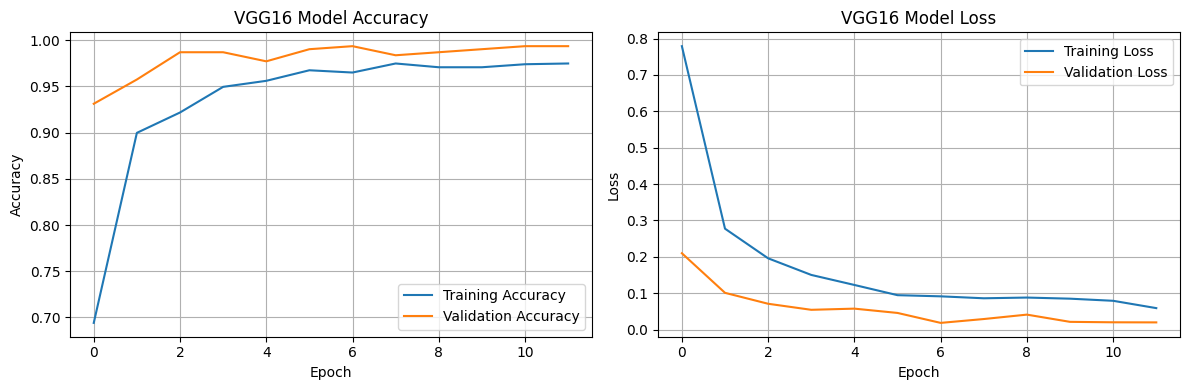

In [15]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Fine-tuning VGG16



In [ ]:
 # OPTIONAL: Fine-tuning
 # Unfreeze the last 4 convolutional blocks
base_model.trainable = True
 
 # Freeze all layers except the last 4 blocks
for layer in base_model.layers[:-4]:
     layer.trainable = False
 
 # Recompile with lower learning rate
model.compile(
     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
     loss='binary_crossentropy',
     metrics=['accuracy']
 )
 
 # Continue training
history_fine = model.fit(
     train_generator,
     epochs=10,
     validation_data=val_generator,
     callbacks=[early_stopping]
 )

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.9763 - loss: 0.1679 - val_accuracy: 0.9902 - val_loss: 0.0794
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.9763 - loss: 0.1679 - val_accuracy: 0.9902 - val_loss: 0.0794
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 178s 5s/step - accuracy: 0.9902 - loss: 0.1134 - val_accuracy: 0.9934 - val_loss: 0.0686
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 178s 5s/step - accuracy: 0.9902 - loss: 0.1134 - val_accuracy: 0.9934 - val_loss: 0.0686
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 181s 5s/step - accuracy: 0.9853 - loss: 0.1039 - val_accuracy: 0.9934 - val_loss: 0.0593
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 181s 5s/step - accuracy: 0.9853 - loss: 0.1039 - val_accuracy: 0.9934 - val_loss: 0.0593
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 181s 5s/step - accuracy: 0.9869 - loss: 0.0893 - val_accuracy: 0.9902 - val_loss: 0.0435
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 181s 5s/step - accuracy: 0.9869 - loss: 0.0893 - val_accuracy: 0.9902 - v

In [16]:
# EVALUATE THE MODEL
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n=== VGG16 MODEL EVALUATION RESULTS ===")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.9970 - loss: 0.0105

=== VGG16 MODEL EVALUATION RESULTS ===
Test Accuracy: 0.9970
Test Loss: 0.0105
21/21 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.9970 - loss: 0.0105

=== VGG16 MODEL EVALUATION RESULTS ===
Test Accuracy: 0.9970
Test Loss: 0.0105


In [17]:
# SAVE THE MODEL
model.save('exercise_6_vgg16_sionosa.h5')
print("Model saved as: exercise_6_vgg16_sionosa.h5")

Model saved as: exercise_6_vgg16_sionosa.h5


In [24]:
# INFERENCE FUNCTION FOR 3-CLASS CLASSIFICATION
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

def predict_image(img_path, use_trained_model=True):
    """
    Predict image class using either the trained model in memory or a saved model file
    """
    if use_trained_model:
        pred_model = model  # Use the model we just trained
    else:
        pred_model = tf.keras.models.load_model('exercise_6_vgg16_sionosa.h5')
    
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    predictions = pred_model.predict(img_array, verbose=0)[0]
    
    # Get class names from the generator
    class_names = {v: k for k, v in train_generator.class_indices.items()}
    predicted_class = np.argmax(predictions)
    label = class_names[predicted_class]
    confidence = predictions[predicted_class]
    
    print(f"Prediction: {label} (confidence: {confidence:.2%})")
    print(f"All probabilities: {dict(zip([class_names[i] for i in range(3)], predictions))}")
    return label, confidence

In [27]:
# TEST PREDICTIONS
print("\n=== VGG16 SAMPLE PREDICTIONS ===")

# Example predictions for each class
import glob

# Test multiple images from each class to verify accuracy
for class_name in ['rock', 'paper', 'scissors']:
    test_class_dir = os.path.join(test_dir, class_name)
    images = glob.glob(os.path.join(test_class_dir, '*.*'))
    
    if images:
        # Test 3 random images from each class
        print(f"\n--- Testing {class_name.upper()} images ---")
        test_samples = np.random.choice(images, min(3, len(images)), replace=False)
        
        correct = 0
        for idx, img_path in enumerate(test_samples, 1):
            filename = os.path.basename(img_path)
            print(f"\nSample {idx}: {filename}")
            predicted_label, conf = predict_image(img_path, use_trained_model=True)
            if predicted_label == class_name:
                correct += 1
                print("✓ Correct prediction")
            else:
                print(f"✗ Wrong! Expected: {class_name}")
        
        print(f"\n{class_name.upper()} Accuracy: {correct}/{len(test_samples)} correct ({100*correct/len(test_samples):.1f}%)")
    else:
        print(f"\nNo {class_name} images found in test set")


=== VGG16 SAMPLE PREDICTIONS ===

--- Testing ROCK images ---

Sample 1: cWKDIx5D1KB0zqjF.png
Prediction: rock (confidence: 100.00%)
All probabilities: {'paper': 1.987317e-06, 'rock': 0.9999943, 'scissors': 3.6777888e-06}
✓ Correct prediction

Sample 2: UPZ5MJAl3AqoLrZV.png
Prediction: rock (confidence: 100.00%)
All probabilities: {'paper': 1.987317e-06, 'rock': 0.9999943, 'scissors': 3.6777888e-06}
✓ Correct prediction

Sample 2: UPZ5MJAl3AqoLrZV.png
Prediction: rock (confidence: 100.00%)
All probabilities: {'paper': 8.814369e-09, 'rock': 1.0, 'scissors': 4.6976485e-11}
✓ Correct prediction

Sample 3: f48wzqwquNrvjICP.png
Prediction: rock (confidence: 100.00%)
All probabilities: {'paper': 8.814369e-09, 'rock': 1.0, 'scissors': 4.6976485e-11}
✓ Correct prediction

Sample 3: f48wzqwquNrvjICP.png
Prediction: rock (confidence: 100.00%)
All probabilities: {'paper': 1.0858158e-05, 'rock': 0.99998915, 'scissors': 8.180264e-09}
✓ Correct prediction

ROCK Accuracy: 3/3 correct (100.0%)

--- T